## Project Overview
The year of 2020 had a historic rise of demonstrations across the United States calling to 'Defund the Police.' The funding trend of increasing police spending was reversed for the first time in years by reducing the Los Angeles Police Department (LAPD) budget by $150 million.

This project analyses the available crime data by simple exploratory data analysis and using Machine learning to predict the crimes that occur in Los Angeles.

## EDA and Data Preparation
Importing the Necessary Libraries and packages


In [1]:
# importing necesary packages
import numpy as np
import pandas as pd
import pickle
import itertools
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
import folium

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


# ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

# importing custom functions
%load_ext autoreload
%autoreload 2
from src import modules


### Loading Datasets

In [2]:
df_2010_to_2019 = pd.read_csv("dataset/Crime_Data_from_2010_to_2019.csv")
df_2020_to_present = pd.read_csv("dataset/Crime_Data_from_2020_to_Present.csv")
   

df_2020_to_present.columns = df_2010_to_2019.columns
df_merged = pd.concat([df_2010_to_2019, df_2020_to_present])

   
print("2010-2019 shape", df_2010_to_2019.shape)
print("2020 to Present shape", df_2020_to_present.shape)
print('Merged DF shape', df_merged.shape) 

2010-2019 shape (2119797, 28)
2020 to Present shape (594977, 28)
Merged DF shape (2714774, 28)


### Data Understanding 
There are 2,714,774 observations over 28 variables. Each row provides a record of information on crime that was reported, location it occurred, time it occurred, crime type, and information on the victims of the crime. The crime date includes the daily crime data collected from January of 2010 to October of 2022. 

In [3]:
# preview of crime data
df_merged.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,1307355,02/20/2010 12:00:00 AM,02/20/2010 12:00:00 AM,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,AA,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695
1,11401303,09/13/2010 12:00:00 AM,09/12/2010 12:00:00 AM,45,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2,70309629,08/09/2010 12:00:00 AM,08/09/2010 12:00:00 AM,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,...,IC,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524
3,90631215,01/05/2010 12:00:00 AM,01/05/2010 12:00:00 AM,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,...,IC,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
4,100100501,01/03/2010 12:00:00 AM,01/02/2010 12:00:00 AM,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",...,IC,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488


In [4]:
df_merged.tail()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
594972,221213384,06/07/2022 12:00:00 AM,06/07/2022 12:00:00 AM,1900,12,77th Street,1249,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,...,AO,Adult Other,626.0,NaN,NaN,NaN,6600 S HOOVER ST,NaN,33.9792,-118.2871
594973,220314584,08/02/2022 12:00:00 AM,08/02/2022 12:00:00 AM,10,3,Southwest,334,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,4300 W 28TH ST,NaN,34.0311,-118.3335
594974,221005507,02/10/2022 12:00:00 AM,02/09/2022 12:00:00 AM,1530,10,West Valley,1024,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,18800 SHERMAN WY,NaN,34.2011,-118.5426
594975,221105477,02/10/2022 12:00:00 AM,02/08/2022 12:00:00 AM,2000,11,Northeast,1171,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,4000 FOUNTAIN AV,NaN,34.0958,-118.2787
594976,221605448,02/15/2022 12:00:00 AM,02/14/2022 12:00:00 AM,1800,16,Foothill,1613,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,...,IC,Invest Cont,331.0,NaN,NaN,NaN,12700 VAN NUYS BL,NaN,34.2755,-118.4092


In [5]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2714774 entries, 0 to 594976
Data columns (total 28 columns):
 #   Column          Dtype  
---  ------          -----  
 0   DR_NO           int64  
 1   Date Rptd       object 
 2   DATE OCC        object 
 3   TIME OCC        int64  
 4   AREA            int64  
 5   AREA NAME       object 
 6   Rpt Dist No     int64  
 7   Part 1-2        int64  
 8   Crm Cd          int64  
 9   Crm Cd Desc     object 
 10  Mocodes         object 
 11  Vict Age        int64  
 12  Vict Sex        object 
 13  Vict Descent    object 
 14  Premis Cd       float64
 15  Premis Desc     object 
 16  Weapon Used Cd  float64
 17  Weapon Desc     object 
 18  Status          object 
 19  Status Desc     object 
 20  Crm Cd 1        float64
 21  Crm Cd 2        float64
 22  Crm Cd 3        float64
 23  Crm Cd 4        float64
 24  LOCATION        object 
 25  Cross Street    object 
 26  LAT             float64
 27  LON             float64
dtypes: float64(8)

In [6]:
df_merged.shape

(2714774, 28)

In [7]:
df_merged['DATE OCC'] = pd.to_datetime(df_merged['DATE OCC'])

In [8]:
# loading pickled cleaned df for reproducibility
clean_df = pd.read_pickle('dataset/cleaned_df.pkl')

### Exporatory Data Analysis
In EDA we have explored data to answer our business problems/questions.  Similarly, in time series the linear relationship between a value and its previous observed value is checked on, by looking at the autocorrelation.

Additionally, decomposition of the time series data to examine seasonality and trends is also done.

#### Business problem 1: Areas in LA with High rate of crime

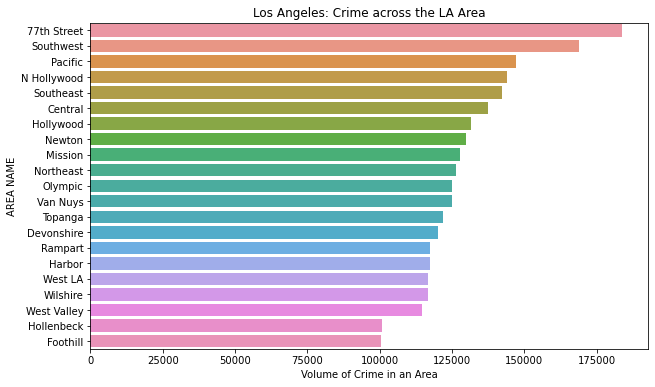

In [9]:
# Setting up figure
plt.figure(figsize=(10,6))

# Plotting categorial count plot for crime by area
sns.countplot(y='AREA NAME', data= clean_df, orient="h", 
              order=clean_df['AREA NAME'].value_counts().index)

# Setting x axis label and figure title
plt.xlabel('Volume of Crime in an Area')
plt.title('Los Angeles: Crime across the LA Area');

In [10]:
clean_df['AREA NAME'].value_counts()[:6]

77th Street    183666
Southwest      168925
Pacific        147145
N Hollywood    144129
Southeast      142372
Central        137440
Name: AREA NAME, dtype: int64

The top 5 areas where most of the crimes in LA have occured among the 21 geographic areas is 77th Street, Southwest, Pacific, North Hollywood, and Southeast.

In [11]:
# creating crime_df with each unique crime and associated area name
crime_df = df_merged[['DR_NO','AREA NAME']]
# renaming columns
crime_df.rename(columns={"DR_NO": "IncidentID", 'AREA NAME':'AREA'}, inplace=True)

# creating crime_counts_df with the count of crime in each area
crime_counts_df = crime_df.groupby('AREA').size().reset_index()
crime_counts_df = crime_counts_df.rename({0: 'num_crimes'}, axis='columns')

# fixing area names so they appear on the map
crime_counts_df['AREA'] = crime_counts_df['AREA'].str.replace('N Hollywood', 'North Hollywood')
crime_counts_df['AREA'] = crime_counts_df['AREA'].str.replace('West LA', 'West Los Angeles')

In [12]:
LAgeo = r'dataset/LAPD_Divisions.json'

mapLACrimes = folium.Map(
    location=[34.052235, -118.243683], 
    zoom_start=10, 
    tiles='cartodbpositron', 
)

mapLACrimes.choropleth(
    geo_data=LAgeo,
    name='choropleth',
    data=crime_counts_df,
    columns=['AREA', 'num_crimes'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Reported Crimes in LA from 2010-2022'
)

In [13]:
mapLACrimes

####  Business problem 2: The Top Impacted Demographics in LA

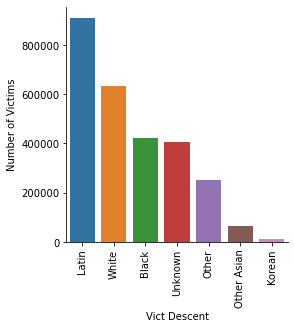

In [14]:
# Plotting  a countplot of Victim Descent
g = sns.catplot(x="Vict Descent", 
                data=clean_df, 
                kind="count",
                height=4, orient="h",
                order=clean_df['Vict Descent'].value_counts()[:7].index)

#setting x labels
g.set_xticklabels(['Latin','White','Black','Unknown', 'Other', 'Other Asian','Korean'], rotation= 'vertical')

#setting y label
g.set_ylabels('Number of Victims')
g.set_titles('Distribution of victims by Descent');

In [15]:
# Proportion of victims sorted in descenting order for the 
clean_df['Vict Descent'].value_counts(normalize= True)[:10]

H    0.335538
W    0.233780
B    0.155506
X    0.150149
O    0.092234
A    0.023555
K    0.004512
F    0.001799
C    0.001128
I    0.000541
Name: Vict Descent, dtype: float64

From the crime data, we can see 33.5% are victoms latina descent which is seen as highest no. of victims of crimes , White victims are 23.7% and third is black victims with 15.5%.during the period of 2010 to mid 2022.

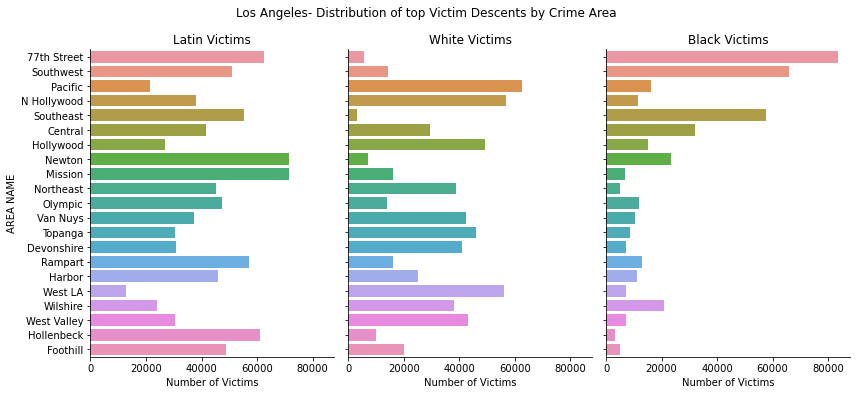

In [16]:
# Plotting a categorical estimate plot of Crime area by Descent
g = sns.catplot(y="AREA NAME", col="Vict Descent",
                col_order= clean_df['Vict Descent'].value_counts()[:3].index
                ,data=clean_df, kind="count",height=5, aspect=.8,
               order=clean_df['AREA NAME'].value_counts().index)

# Setting label an title for first facet
g.axes[0,0].set_xlabel('Number of Victims')
g.axes[0,0].set_title('Latin Victims')

# Setting label an title for second facet
g.axes[0,1].set_xlabel('Number of Victims')
g.axes[0,1].set_title('White Victims')

# Setting label an title for third facet
g.axes[0,2].set_xlabel('Number of Victims')
g.axes[0,2].set_title('Black Victims')

#setting figure title for facetgrid plot
g.fig.suptitle('Los Angeles- Distribution of top Victim Descents by Crime Area ', y = 1.05);

As our observation above, we see the top vulnerable demographics in LA is Black and Latina communities. The highest crime area seems to be 77th street and Southwest in LA . White community seems to be least vulernable but the reason could be there are less white population compared to others in those area.

#### Business problem 3: Crime changes during the time period of study

In [17]:
# grouping data by date in index
crime_volume = pd.DataFrame(clean_df.groupby(clean_df.index.date).size(), columns=['crime_count']).reset_index()

# pulling out date from index to convert to datetime object
crime_volume.rename(columns = {'index':'Date'}, inplace = True)

# converting Date column to datetime object
crime_volume['Date']= pd.to_datetime(crime_volume['Date'], format='%Y-%m-%d')

# setting datetime object as index
crime_volume.set_index('Date', inplace=True)

# resample monthly average crime from datetime index
monthly_crime=round(crime_volume.resample('MS').mean(),2)


In [18]:
# grouping data annually
year_groups= monthly_crime.groupby(pd.Grouper(freq='A'))

# create a new DataFrame and store yearly values in columns 
annual_crime = pd.DataFrame()

# looping through the year_unemp groupby object as a tuple
for date,group in year_groups:
    year = date.year          
    if year == 2022:          # removing year for incomplete data
        break
    series = group.values.ravel()  # flattening the array
    annual_crime[year] = series
    
# uncomment code below to preview data
# annual_crime.head() 

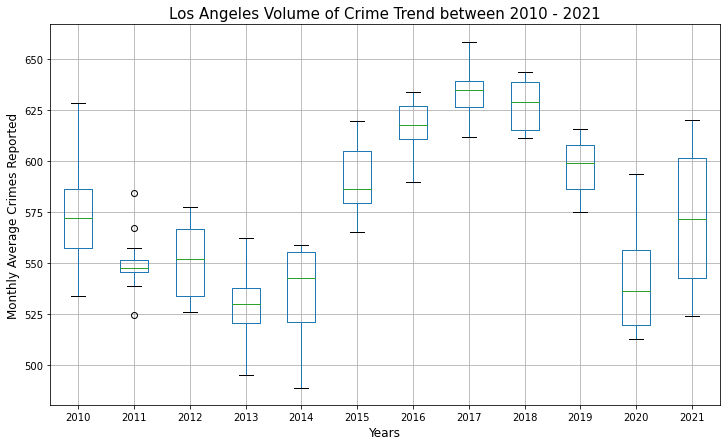

In [19]:
# generating a box and whiskers plot for last 11 years
annual_crime.boxplot(figsize=(12,7))

# setting figure title
plt.title('Los Angeles Volume of Crime Trend between 2010 - 2021', size = 15)

# setting x and y label
plt.xlabel('Years', size=12)
plt.ylabel('Monthly Average Crimes Reported', size = 12)

# display graph
plt.show();

From the observation above, we can see that 2017 saw the highest average number of crimes reported, while 2013 saw the lowest average number of crimes reported in LA.
And also see the decreasing trend of average crime from 2017 to 2020.

### Crime trend in LA between 2010 and 2022

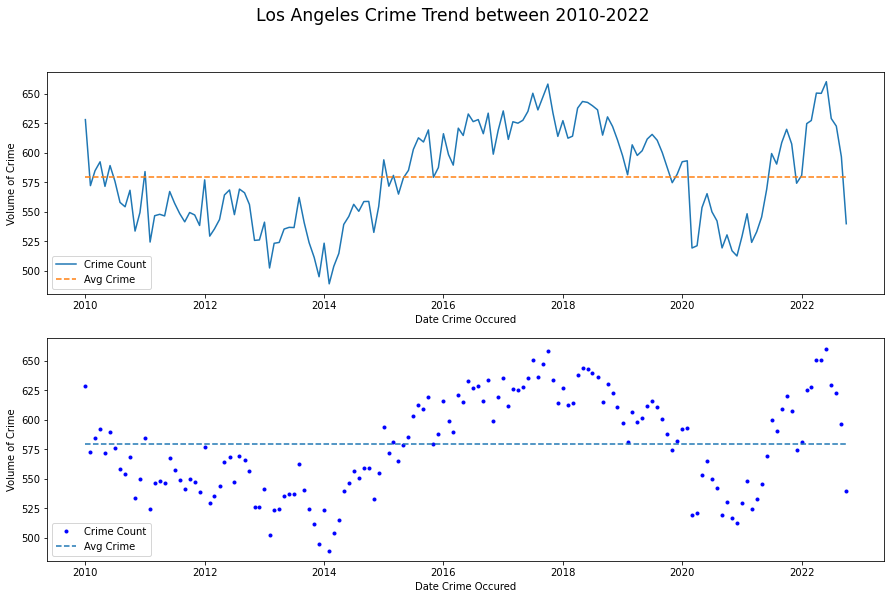

In [20]:
crime_trend,axs = plt.subplots(2,figsize=(15,9))
crime_trend.suptitle('Los Angeles Crime Trend between 2010-2022', size = 'xx-large')

#calculating average for avg line
avg = y_mean = [np.mean(monthly_crime['crime_count']) for i in monthly_crime['crime_count']]

axs[0].plot(monthly_crime
            , label='Crime Count')
axs[0].plot(monthly_crime.index, avg, label = 'Avg Crime', linestyle= '--')

axs[0].set_xlabel('Date Crime Occured')
axs[0].set_ylabel('Volume of Crime')

axs[1].plot(monthly_crime,'.b',label='Crime Count' )
axs[1].plot(monthly_crime.index, avg, label = 'Avg Crime', linestyle= '--')

axs[1].set_xlabel('Date Crime Occured')
axs[1].set_ylabel('Volume of Crime')

#legend location
axs[0].legend(loc='lower left')
axs[1].legend(loc='lower left')

### Autocorrelation
Checking the Autocorrelation function (ACF) plot or correlogram and the Partial Autocorrelation Function (PACF) plots

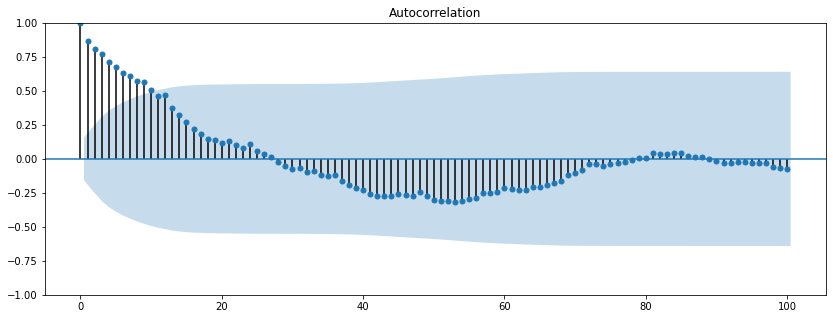

In [21]:
rcParams['figure.figsize'] = 14, 5

plot_acf(monthly_crime, lags=100, alpha=0.05);

From the ACF plot we understand that at a 95% confidence (shown by the shaded area), only the first few lags or up to 9 lags have a significant correlation, i.e, that the series is strongly correlated only for the first couple of lags and decays after that.

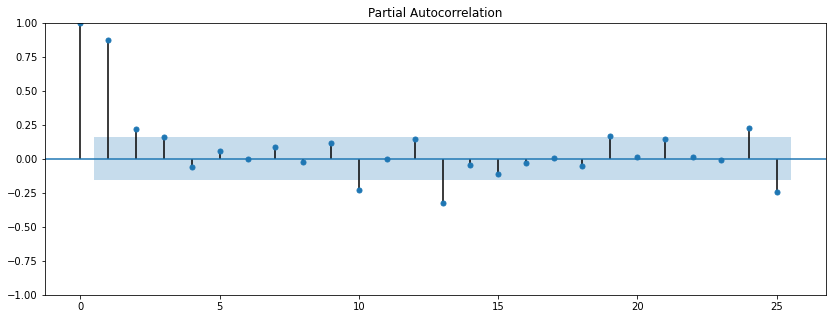

In [22]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(monthly_crime, lags=25, alpha=0.05);

From the PACF plot we see that the time series is significant for the PACF up to 3 lags

### Trend
Check on trend to do a seasonal decomposition on the data, specially for data that fluctuates in time.

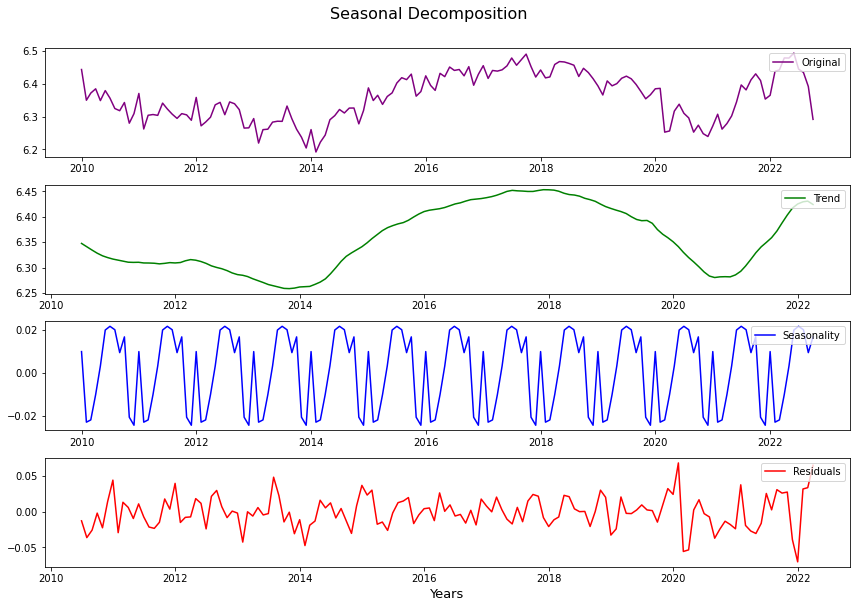

In [23]:
# instantiating decomposition object
decomposition = seasonal_decompose(np.log(monthly_crime))

# gathering the trend, seasonality, and residuals for the monthly crime data
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plot gathered statistics
plt.figure(figsize=(12,8))
plt.suptitle('Seasonal Decomposition', y = 1.05, size = 16)

# plotting original data in a subplot and showing legend
plt.subplot(411)
plt.plot(np.log(monthly_crime), label='Original', color='purple')
plt.legend(loc=1)

# plotting decomposed trend in a subplot and showing legend
plt.subplot(412)
plt.plot(trend, label='Trend', color='green')
plt.legend(loc=1)

# plotting decomposed seasonality in a subplot and showing legend
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc=1)

# plotting decomposed residual or noise in a subplot and showing legend
plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc=1)
plt.xlabel('Years', size= 13)

plt.tight_layout()

The first subplot on the very top shows the plot for the original data with no decomposition. The second subplot shows a clear smooth trend pattern in the data. This is clear evidence of a non-constant mean.The third subplot shows the decomposed seasonality pattern in the data. The last subplot shows the noise or residual component in the time series data.

We also looked at the rolling statistics to confirm any instances of non-stationarity.

In [24]:
# calculating rolling mean and rolling standard deviation
roll_mean = monthly_crime.rolling(window=4, center=False).mean()
roll_std = monthly_crime.rolling(window=4, center=False).std()

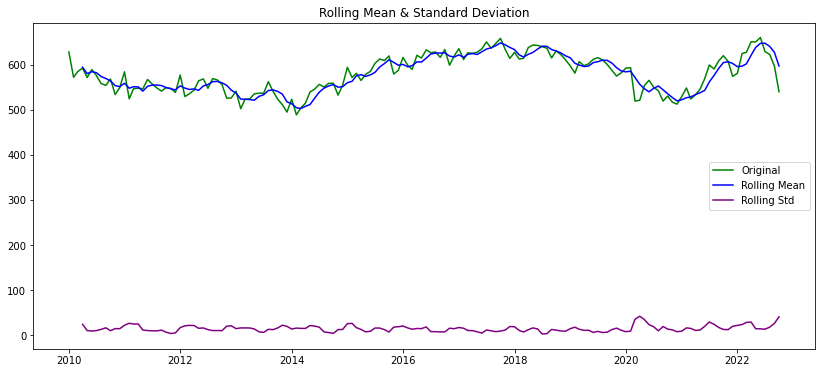

In [25]:
fig = plt.figure(figsize=(14,6))
plt.plot(monthly_crime, color='green', label='Original')
# rolling mean
plt.plot(roll_mean, color='blue', label='Rolling Mean')
# standard deviation
plt.plot(roll_std, color='purple', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## Modeling ##
To model time series data, we need to achieve stationarity in the time series. Since, our data in the current state is not stationary, we first attempted differencing at different orders and checking for stationarity.

#### Differencing

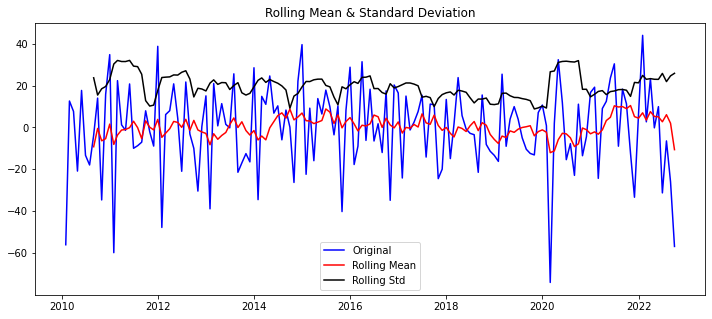

Results of Dickey-Fuller Test: 

Test Statistic                  -2.682498
p-value                          0.077116
#Lags Used                      11.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64


In [26]:
#Differencing at 1 period 
crime_diff1 = monthly_crime.diff(periods=1)

#dropping any Nan values
crime_diff1.dropna(inplace=True)

#running stationarity check
modules.stationarity_check(crime_diff1)

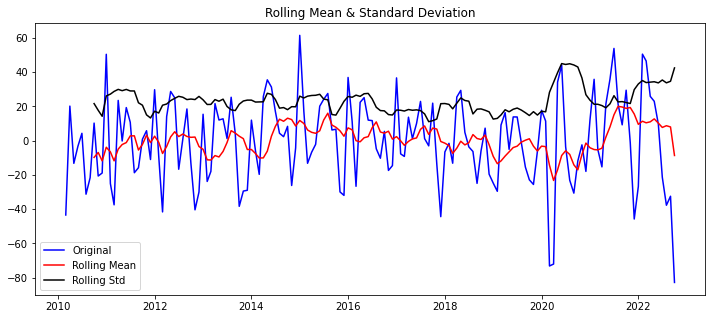

Results of Dickey-Fuller Test: 

Test Statistic                  -2.614075
p-value                          0.090123
#Lags Used                      10.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64


In [27]:
# differencing at 2nd order 
crime_diff2 = monthly_crime.diff(periods=2)

#dropping any Nan values
crime_diff2.dropna(inplace=True)

# running stationarity check 
modules.stationarity_check(crime_diff2)

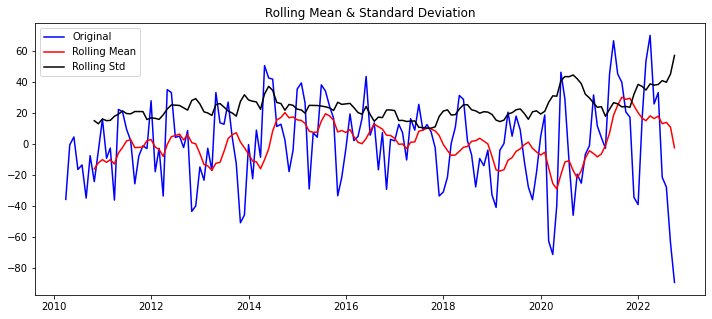

Results of Dickey-Fuller Test: 

Test Statistic                  -2.703400
p-value                          0.073452
#Lags Used                       9.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64


In [28]:
# differencing at 3rd order 
crime_diff3 = monthly_crime.diff(periods=3)

# dropping any Nan values
crime_diff3.dropna(inplace=True)

# running stationarity check
modules.stationarity_check(crime_diff3)

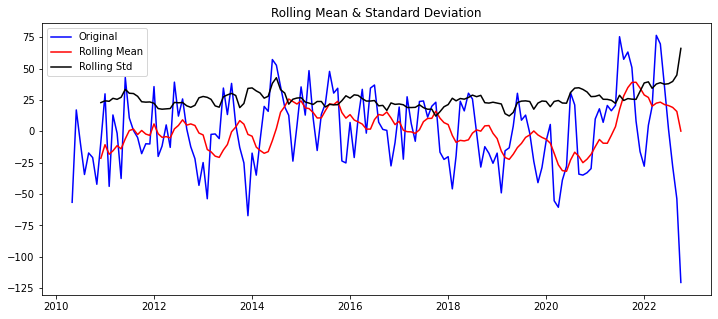

Results of Dickey-Fuller Test: 

Test Statistic                  -2.558759
p-value                          0.101824
#Lags Used                       8.000000
Number of Observations Used    141.000000
Critical Value (1%)             -3.477601
Critical Value (5%)             -2.882266
Critical Value (10%)            -2.577822
dtype: float64


In [29]:
# differencing at 4th order 
crime_diff4 = monthly_crime.diff(periods=4)

# dropping any Nan values
crime_diff4.dropna(inplace=True)

# running stationarity check
modules.stationarity_check(crime_diff4)

subtract the moving average from the original data and previewing the roll_mean value comes from the Rolling Statistics calculated above

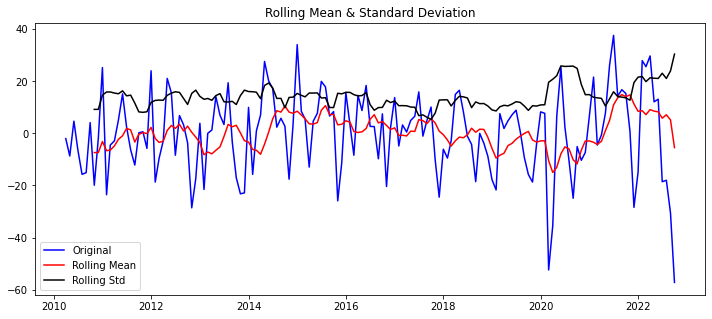

Results of Dickey-Fuller Test: 

Test Statistic                  -2.693312
p-value                          0.075203
#Lags Used                      12.000000
Number of Observations Used    138.000000
Critical Value (1%)             -3.478648
Critical Value (5%)             -2.882722
Critical Value (10%)            -2.578065
dtype: float64


In [30]:
minus_roll_mean = monthly_crime - roll_mean

# removing Nans
minus_roll_mean.dropna(inplace=True)

# running stationarity check
modules.stationarity_check(minus_roll_mean)

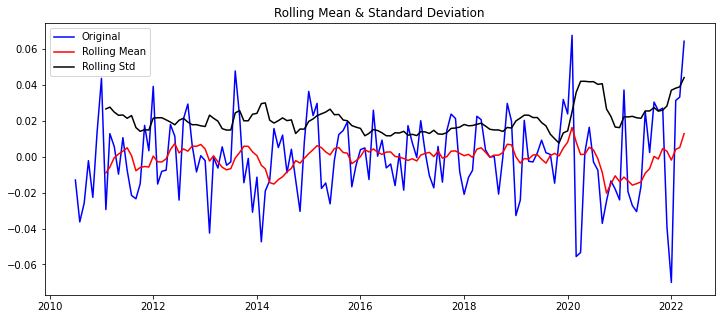

Results of Dickey-Fuller Test: 

Test Statistic                -8.397525e+00
p-value                        2.277695e-13
#Lags Used                     2.000000e+00
Number of Observations Used    1.390000e+02
Critical Value (1%)           -3.478294e+00
Critical Value (5%)           -2.882568e+00
Critical Value (10%)          -2.577983e+00
dtype: float64


In [31]:
# residual value comes from the code block on Seasonal Decomposition
crime_log_decompose = residual

# drop missing values from residuals 
crime_log_decompose.dropna(inplace=True)

# running stationarity check
modules.stationarity_check(crime_log_decompose)

The expanded form for the dickey fuller test p- value is 0.000000000002277. At a 95% confidence, this is clearly less than the p critical value of 0.05. Here we reject the null of non-stationarity and state that there is statistical evidence that the residuals are stationary.

# Baseline Models

In [32]:

# montly crime count
Xo = monthly_crime.index
# target
yo = monthly_crime['crime_count']


train_seto = monthly_crime.loc['2010-01-01':'2018-12-31']
test_seto = monthly_crime.loc['2019-01-01' : ]

X_traino, X_testo = train_seto.index , test_seto.index
y_traino, y_testo = train_seto['crime_count'] , test_seto['crime_count']

In [33]:
# dictionary to collect model evaluations
model = ARIMA(y_traino, order=(1,0,0))

In [34]:
# dictionary to collect model evaluations
mod_eval={}

In [35]:
# instantiate an AR(1) model to the simulated data
res_arma = model.fit()

# adding aic eval to mod eval dict
mod_eval['AR-1_aic']= res_arma.aic

In [36]:
res_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            crime_count   No. Observations:                  108
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -472.642
Date:                Sun, 11 Dec 2022   AIC                            951.285
Time:                        20:09:10   BIC                            959.331
Sample:                    01-01-2010   HQIC                           954.547
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        583.7756     17.188     33.964      0.000     550.088     617.463
ar.L1          0.8895      0.050     17.735      0.000       0.791       0.988
sigma2       365.1466     50.100      7.288      0.000     266.953     463.340
===================================================================================
Ljung-Box (L1) (Q):                  10.71   Jarque-Bera (JB):                 8.39
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.53   Skew:                            -0.66
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
# Get predictions starting calculate confidence intervals
#pred = res_arma.predict(start='01/01/2020', end='10/31/2022',dynamic=False)

pred = res_arma.predict(start='2019-01-01', end='2022-10-01',dynamic=False)


# Compute the mean square error
rmse = np.sqrt(((pred - y_testo)**2).mean())

#adding rmse eval to mod eval dict
mod_eval['AR-1_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our predictions is 39.87


## MA model on original dataset

In [38]:
# instantiate an MA(1) model to the simulated data
mod2_arma = ARIMA(y_traino, order=(0,0,1))

# fitting model
res_arma2 = mod2_arma.fit()

# adding aic eval to mod eval dict
mod_eval['MA-1_aic']= res_arma2.aic

# running model statistics
res_arma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            crime_count   No. Observations:                  108
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -516.050
Date:                Sun, 11 Dec 2022   AIC                           1038.101
Time:                        20:09:10   BIC                           1046.147
Sample:                    01-01-2010   HQIC                          1041.363
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        578.8721      4.870    118.855      0.000     569.326     588.418
ma.L1          0.7438      0.080      9.327      0.000       0.587       0.900
sigma2       821.5154    135.514      6.062      0.000     555.912    1087.119
===================================================================================
Ljung-Box (L1) (Q):                  16.15   Jarque-Bera (JB):                 2.49
Prob(Q):                              0.00   Prob(JB):                         0.29
Heteroskedasticity (H):               1.60   Skew:                            -0.23
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

For a simple MA(1) model, the AIC score for the model is 1038.527. The coefficients of the model are also significant at the 95% confidence level, with a p-values of less than 0.05.

In [39]:
# get predictions and calculate confidence intervals
pred = res_arma2.predict(start='2019-01-01', end='2022-10-01',dynamic=False)

# compute the mean square error
rmse = np.sqrt(((pred - y_testo)**2).mean())

# adding rmse eval to mod eval dict
mod_eval['MA-1_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our predictions is 39.43


In [40]:
mod_eval

{'AR-1_aic': 951.2846329488182,
 'AR-1_rmse': 39.86959551019193,
 'MA-1_aic': 1038.1007356871173,
 'MA-1_rmse': 39.43178765257478}

## AR model on differenced dataset

Using the 3rd order differenced time series. First we split the 3rd order differenced time series.

In [41]:
X = crime_diff3.index
y = crime_diff3['crime_count']

train_set = crime_diff3.loc['2010-01-01':'2018-12-31']
test_set = crime_diff3.loc['2019-01-01' : ]

X_train, X_test = train_set.index , test_set.index
y_train, y_test = train_set['crime_count'] , test_set['crime_count']

In [42]:
# instantiate an AR(1) model to the simulated data
mod3_arma = ARIMA(y_train, order=(1,0,0))

# fitting model
res_arma3 = mod3_arma.fit()

#adding aic eval to mod eval dict
mod_eval['AR-1-diff_aic']= res_arma3.aic

# running model statistics
res_arma3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            crime_count   No. Observations:                  105
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -465.533
Date:                Sun, 11 Dec 2022   AIC                            937.065
Time:                        20:09:10   BIC                            945.027
Sample:                    04-01-2010   HQIC                           940.292
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5028      3.218      0.156      0.876      -5.805       6.810
ar.L1          0.3880      0.097      4.003      0.000       0.198       0.578
sigma2       414.8254     60.314      6.878      0.000     296.612     533.039
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.81   Prob(JB):                         0.96
Heteroskedasticity (H):               0.57   Skew:                            -0.05
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

For a simple AR(1) model on the 3rd order differenced time series, the AIC score for the model is 937.065. The coefficients of the constant in the model is not significant while the ar.L1 coefficient is significant at the 95% confidence level, with a p-values of less than 0.05.

In [43]:
# get predictions and calculate confidence intervals
pred = res_arma3.predict(start= '2019-01-01' , end= '2022-10-01',dynamic=False)

# compute the mean square error
rmse = np.sqrt(((pred - y_test)**2).mean())

#adding rmse eval to mod eval dict
mod_eval['AR-1-diff_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our predictions is 36.4


In [44]:
mod_eval

{'AR-1_aic': 951.2846329488182,
 'AR-1_rmse': 39.86959551019193,
 'MA-1_aic': 1038.1007356871173,
 'MA-1_rmse': 39.43178765257478,
 'AR-1-diff_aic': 937.0654824240896,
 'AR-1-diff_rmse': 36.40421496890848}

In [45]:
# instantiate an MA(1) model to the simulated data
mod4_arma = ARIMA(y_train, order=(0,0,1))

# fitting model
res_arma4 = mod4_arma.fit()

# adding aic eval to mod eval dict
mod_eval['MA-1-diff_aic']= res_arma4.aic

# running model statistics
res_arma4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            crime_count   No. Observations:                  105
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -467.807
Date:                Sun, 11 Dec 2022   AIC                            941.613
Time:                        20:09:11   BIC                            949.575
Sample:                    04-01-2010   HQIC                           944.840
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6519      2.605      0.250      0.802      -4.454       5.758
ma.L1          0.2831      0.095      2.994      0.003       0.098       0.468
sigma2       433.5170     65.543      6.614      0.000     305.055     561.979
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):                 0.39
Prob(Q):                              0.43   Prob(JB):                         0.82
Heteroskedasticity (H):               0.62   Skew:                            -0.07
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
# get predictions and calculate confidence intervals
pred = res_arma4.predict(start='2019-01-01', end='2022-10-01',dynamic=False)

# compute the mean square error
rmse = np.sqrt(((pred - y_test)**2).mean())

# adding rmse eval to mod eval dict
mod_eval['MA-1-diff_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))


The Root Mean Squared Error of our predictions is 36.46


In [47]:
mod_eval

{'AR-1_aic': 951.2846329488182,
 'AR-1_rmse': 39.86959551019193,
 'MA-1_aic': 1038.1007356871173,
 'MA-1_rmse': 39.43178765257478,
 'AR-1-diff_aic': 937.0654824240896,
 'AR-1-diff_rmse': 36.40421496890848,
 'MA-1-diff_aic': 941.6134725254254,
 'MA-1-diff_rmse': 36.46315036231748}

# ARMA model

In [48]:
# define the p, d and q parameters to take any value between 0 and 2

pdq = []

for i in range(1,6):
    for j in range(1,6):
        pdq.append([i,0,j])



In [49]:
# run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
        mod = ARIMA(y_train, order= comb)
        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARMA {} : AIC Calculated ={}'.format(comb,output.aic))

ARMA [1, 0, 1] : AIC Calculated =939.0022420558939
ARMA [1, 0, 2] : AIC Calculated =901.2547012924421
ARMA [1, 0, 3] : AIC Calculated =901.3304977260032
ARMA [1, 0, 4] : AIC Calculated =902.9505107060635
ARMA [1, 0, 5] : AIC Calculated =904.7257759110031
ARMA [2, 0, 1] : AIC Calculated =938.5948835388475
ARMA [2, 0, 2] : AIC Calculated =901.7602991566056
ARMA [2, 0, 3] : AIC Calculated =902.7979573294214
ARMA [2, 0, 4] : AIC Calculated =904.8299227288741
ARMA [2, 0, 5] : AIC Calculated =906.0641714841363
ARMA [3, 0, 1] : AIC Calculated =932.064762202371
ARMA [3, 0, 2] : AIC Calculated =903.655959957012
ARMA [3, 0, 3] : AIC Calculated =904.8708855798792
ARMA [3, 0, 4] : AIC Calculated =901.6609540363409
ARMA [3, 0, 5] : AIC Calculated =900.1319361270089
ARMA [4, 0, 1] : AIC Calculated =934.0510036158859
ARMA [4, 0, 2] : AIC Calculated =905.0111172987774
ARMA [4, 0, 3] : AIC Calculated =906.4457680779769
ARMA [4, 0, 4] : AIC Calculated =911.0174486979731
ARMA [4, 0, 5] : AIC Calculated =

In [50]:
# find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq     [3, 0, 5]
aic    900.131936
Name: 14, dtype: object

In [51]:
# instantiate an AR(1) model to the simulated data
mod5_arma = ARIMA(y_train, order=(3,0,5))

# fitting model
res_arma5 = mod5_arma.fit()

# adding aic eval to mod eval dict
mod_eval['ARMA-3,0,5-diff_aic']= res_arma5.aic

# running model statistics
res_arma5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            crime_count   No. Observations:                  105
Model:                 ARIMA(3, 0, 5)   Log Likelihood                -440.066
Date:                Sun, 11 Dec 2022   AIC                            900.132
Time:                        20:09:19   BIC                            926.672
Sample:                    04-01-2010   HQIC                           910.886
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6897      3.240      0.213      0.831      -5.660       7.040
ar.L1          0.9326      0.278      3.358      0.001       0.388       1.477
ar.L2         -0.9091      0.094     -9.628      0.000      -1.094      -0.724
ar.L3          0.7674      0.244      3.146      0.002       0.289       1.246
ma.L1         -0.2444      0.270     -0.907      0.365      -0.773       0.284
ma.L2          1.0552      0.230      4.586      0.000       0.604       1.506
ma.L3         -0.9228      0.369     -2.503      0.012      -1.645      -0.200
ma.L4          0.3450      0.278      1.243      0.214      -0.199       0.889
ma.L5         -0.8887      0.283     -3.145      0.002      -1.443      -0.335
sigma2       254.7162     67.735      3.760      0.000     121.957     387.475
===================================================================================
Ljung-Box (L1) (Q):                   2.06   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.15   Prob(JB):                         0.70
Heteroskedasticity (H):               0.40   Skew:                            -0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
# get predictions and calculate confidence intervals
pred_arma5 = res_arma5.predict(start='2019-01-01', end='2022-10-01',dynamic=False)

# compute the mean square error
rmse = np.sqrt(((pred_arma5 - y_test)**2).mean())

# adding rmse eval to mod eval dict
mod_eval['ARMA-3,0,5-diff_rmse']= rmse

print('The Root Mean Squared Error of our predictions is {}'.format(round(rmse, 2)))


The Root Mean Squared Error of our predictions is 36.26


In [53]:
mod_eval

{'AR-1_aic': 951.2846329488182,
 'AR-1_rmse': 39.86959551019193,
 'MA-1_aic': 1038.1007356871173,
 'MA-1_rmse': 39.43178765257478,
 'AR-1-diff_aic': 937.0654824240896,
 'AR-1-diff_rmse': 36.40421496890848,
 'MA-1-diff_aic': 941.6134725254254,
 'MA-1-diff_rmse': 36.46315036231748,
 'ARMA-3,0,5-diff_aic': 900.1319361270089,
 'ARMA-3,0,5-diff_rmse': 36.26201937422288}

# SARIMAX model


In [54]:
import itertools

# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [55]:
# run a grid search with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(y_traino,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue


ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =1682.8643022767953
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1687.2977140148312
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =1483.2950816118398
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =925.6621310175431
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =924.7283256170734
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =1833.5301557301684
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =854.534912289022
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =839.4297365618788
ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =4232.2362680040615
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1115.2357198968969
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1114.2731160066692
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =1115.1033275444472
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =924.366844802413
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =926.3314606939556
ARIMA (0, 0, 0

ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =874.7593330538607
ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =876.6866266705789
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =778.4753196592719
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =778.6957909659633
ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3176.969795603073
ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =734.7164175525575
ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =722.8949628787492
ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =723.9458474932359
ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =873.322685468671
ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =874.7995741902082
ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =876.4578394158527
ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =780.4397131948156
ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =782.2665563543733
ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =1508.580851320616
ARIMA (0, 1, 1) x (2,

ARIMA (0, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =873.1698073566107
ARIMA (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =874.7272010995267
ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =780.6413200007535
ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =782.4733222668398
ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3614.871440999082
ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =729.412380481861
ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =724.5467727063592
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =960.8432282854416
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =964.1766713117369
ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =916.4255721083246
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =812.1120568468183
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =793.2111348995918
ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =3526.716396753891
ARIMA (1, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =798.9361621489587
ARIMA (1, 0, 0) x (0,

ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =778.9747838192399
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =2037.0513743114109
ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =792.7284068183229
ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =736.2821147041263
ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3037.0954498976225
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =884.5011242872566
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =876.7507300766673
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =878.6759467402152
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =780.4744926588245
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =780.6942564619118
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =1783.2868571769513
ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =735.8733204923872
ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =724.8884918951827
ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =725.9359637623617
ARIMA (1, 1, 1) x

ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =725.1356250578979
ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3208.4793181229443
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =873.6363664148579
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =875.1206114664561
ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =876.8742682095192
ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =782.5036282464747
ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =784.4239367378906
ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =4498.247162042917
ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =731.2723350417934
ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =726.5425782207632
ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3143.1039064942092
ARIMA (2, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =946.4443995411953
ARIMA (2, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =924.5609792683189
ARIMA (2, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =902.091098145457
ARIMA (2, 0, 0) x (

ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =904.567917285961
ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =884.8891393886842
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =802.1311351314351
ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =780.8827183536707
ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =4495.615996916823
ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =792.0405913709518
ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =737.6893722061234
ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3606.1519638909754
ARIMA (2, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =886.3454958505099
ARIMA (2, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =878.2001868013091
ARIMA (2, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =880.0027646846986
ARIMA (2, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =782.3879250814368
ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =782.5614522455918
ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =2730.4033523134635
ARIMA (2, 1, 1) x (

ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =782.4427860948852
ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =783.569480543652
ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =4357.80190629247
ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =736.7895470709774
ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =728.0701630202745
ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3943.8505394095782
ARIMA (2, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =874.9163682998744
ARIMA (2, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =876.5228646836364
ARIMA (2, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =878.0814662806705
ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =785.6816700612637
ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =787.3667492872773
ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =2539.0007829566125
ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =732.8588599680368
ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =728.6914245643708
ARIMA (2, 2, 2) x (2

In [56]:
# find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
# ans_df.loc[ans_df['aic'].idxmin()]
ans_df.sort_values(by=['aic']).head(50)

,pdq,pdqs,aic
264,"(1, 0, 0)","(2, 1, 2, 12)",12.000000
454,"(1, 2, 1)","(2, 2, 2, 12)",14.000000
722,"(2, 2, 2)","(2, 2, 2, 12)",18.000000
123,"(0, 1, 1)","(1, 2, 1, 12)",722.894963
231,"(0, 2, 2)","(1, 2, 1, 12)",723.264082
338,"(1, 1, 0)","(1, 2, 1, 12)",723.561756
132,"(0, 1, 1)","(2, 2, 1, 12)",723.938518
124,"(0, 1, 1)","(1, 2, 2, 12)",723.945847
444,"(1, 2, 1)","(1, 2, 1, 12)",724.214998
347,"(1, 1, 0)","(2, 2, 1, 12)",724.317369


WE have taken AIC score of 722.894963 for SARIMA model because the other lowest value is too good to be true.

In [57]:
# plug the optimal parameter values into a new SARIMAX model
SARIMA_mod6 = SARIMAX(y_traino, order=(0, 1, 1), 
                                        seasonal_order=(1, 2, 1,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

# fit the model and print results
output = SARIMA_mod6.fit()

# adding aic eval to mod eval dict
mod_eval['SARIMA_aic']= output.aic

output.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        crime_count   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(1, 2, 1, 12)   Log Likelihood                -295.929
Date:                            Sun, 11 Dec 2022   AIC                            599.857
Time:                                    20:23:36   BIC                            608.794
Sample:                                01-01-2010   HQIC                           603.403
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3052      0.103     -2.968      0.003      -0.507      -0.104
ar.S.L12      -0.5537      0.152     -3.647      0.000      -0.851      -0.256
ma.S.L12      -0.7304      0.279     -2.619      0.009      -1.277      -0.184
sigma2       276.6140     67.634      4.090      0.000     144.054     409.174
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.08
Prob(Q):                              0.97   Prob(JB):                         0.96
Heteroskedasticity (H):               0.53   Skew:                             0.07
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
# get predictions and calculate confidence intervals
pred = output.get_prediction(start='2019-01-01', end='2022-10-01',dynamic=False)
# start='2020-01-01', end='2022-10-31'
pred_conf = pred.conf_int()
pred_conf.head()

,lower crime_count,upper crime_count
2019-01-01,586.792796,652.329493
2019-02-01,566.741021,646.484482
2019-03-01,568.176240,659.953048
2019-04-01,576.431597,678.837443
2019-05-01,576.140851,688.171793


In [59]:
# get the real and predicted values
Crime_forecasted = pred.predicted_mean
Crime_truth = y_testo

# compute the mean square error
rmse = np.sqrt(((Crime_forecasted - Crime_truth)**2).mean())



# adding rmse eval to mod eval dict
mod_eval['SARIMA_rmse']= rmse

print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 51.8


In [60]:
mod_eval

{'AR-1_aic': 951.2846329488182,
 'AR-1_rmse': 39.86959551019193,
 'MA-1_aic': 1038.1007356871173,
 'MA-1_rmse': 39.43178765257478,
 'AR-1-diff_aic': 937.0654824240896,
 'AR-1-diff_rmse': 36.40421496890848,
 'MA-1-diff_aic': 941.6134725254254,
 'MA-1-diff_rmse': 36.46315036231748,
 'ARMA-3,0,5-diff_aic': 900.1319361270089,
 'ARMA-3,0,5-diff_rmse': 36.26201937422288,
 'SARIMA_aic': 599.8573643486835,
 'SARIMA_rmse': 51.79607577249585}

# Final Model Analysis

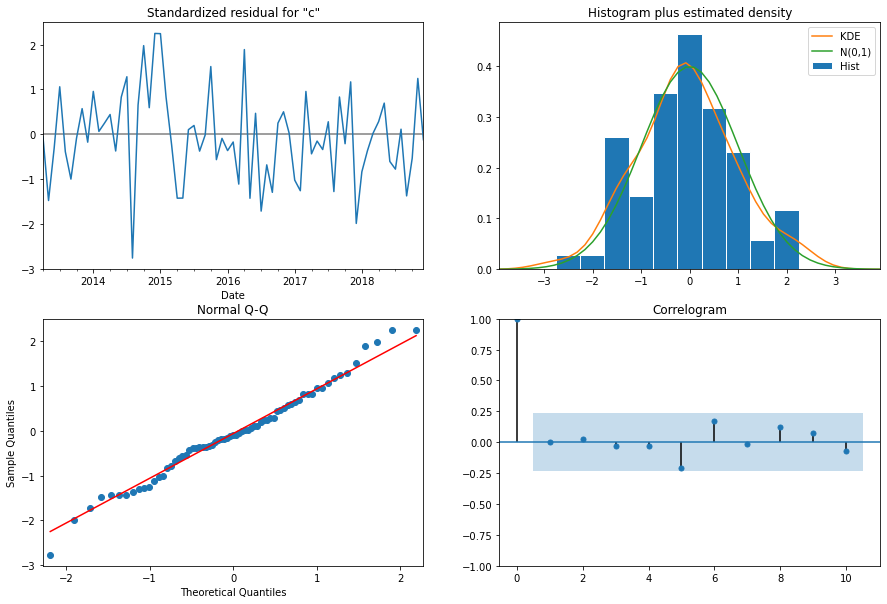

In [61]:
# call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 10)) 
# save figure as image
plt.show()


#### Checking for these assumptions from diagnostics plots:

1. In the top right plot, we see that the orange KDE line follows closely with the N(0,1) line. This tells us that there is a good indication that the residuals are close to normally distributed i.e., has a close to a zero mean.

2. The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) weakly follows the linear trend of the samples taken from a standard normal distribution with N(0, 1).There is fair indication that the residuals are normally distributed, i.e., follows a close to zero mean.

3. The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself, i.e., Uncorrelated residuals

These observations lead us to conclude that our model residuals pass both assumptions of a zero mean and no or weak correlation. Hence, there is evidence to believe that our model uses all the information available in the model to make appropriate forecasts that are unbiased.

In [ ]:
# plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

# plot observed values
ax = monthly_crime['2019-01-01':].plot(label='observed')
# plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)
# plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# set axes labels and title
ax.set_xlabel('Date', size=12)
ax.set_ylabel('Crime Levels',size=12)
ax.set_title('Real vs Predicted for SARIMA with (1,2,1,12) Parameters', size=15)
# adding legend
plt.legend()
plt.show()

In [63]:

# get forecast 48 steps ahead in future
prediction = output.get_forecast(steps=48)

# get confidence intervals of forecasts
pred_conf = prediction.conf_int()

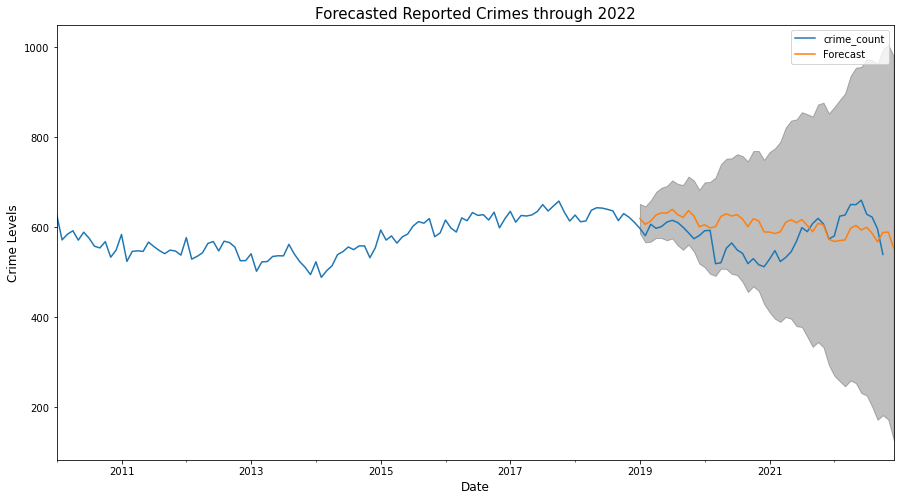

In [64]:

# plot future predictions with confidence intervals
ax = monthly_crime.plot(label='observed', figsize=(15, 8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)

# setting axes labels and title
ax.set_xlabel('Date', size = 12)
ax.set_ylabel('Crime Levels', size = 12)
ax.set_title('Forecasted Reported Crimes through 2022', size = 15)

plt.legend()
plt.show()

Once the final model was predicted we ran a diagnostic to confirm that the residuals pass the assumptions of zero mean and weak correlation. The residuals from our best model passed the assumptions implying that the model uses all information in the data to make forecasts and that the forecasts are unbiased.

On plotting the forecast as shown in the image above, we find that as the number of forecast steps (here steps =48) are increased the forecasted values stray above and away from the observed values. The confidence interval (shaded area) for the forecasts also exponentially increase with additional number of steps.